In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE # Pour avoir 50 % de 0 et 50 % de 1 dans la colonne presence_accident
from sklearn.linear_model import LogisticRegression # Regression logistique
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold #KFold répété, pour mieux entraîner le modèle
from sklearn.model_selection import train_test_split
import seaborn as sns #Tableau des corrélations
import matplotlib.pyplot as plt 
import plotly.express as px # Pour faire des graphes dans l'interface Dash

**Importation du dataframe df_utiles traité dans prep_df_utiles.ipynb**

In [2]:
df_utiles = pd.read_csv("df_utiles.csv")

In [3]:
df_utiles['lat'] = df_utiles['lat'].str.replace(',', '.').astype(float)
df_utiles['long'] = df_utiles['long'].str.replace(',', '.').astype(float)

# Pour avoir les coordonnées GPS en float, sinon plotly.express (px) ne peut pas les afficher sur la carte de France

In [4]:
df_utiles.columns # Liste des colonnes

Index(['Unnamed: 0', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'agg', 'int',
       'atm', 'col', 'lat', 'long', 'place', 'catu', 'grav', 'sexe', 'an_nais',
       'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp', 'catr',
       'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'surf', 'infra',
       'situ', 'vma', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor'],
      dtype='object')

In [5]:
# On recode catv pour regrouper les véhicules en catégories:
# 1 : véhicules légers (VL, VU)
# 2 : Sans permis (< 125 cm3)
# 3 : Poids lourds
# 4 : transports en commun
# 5 : > 125 cm3

def func(x):
    if x in [7,10]:
        x=1; 
    elif (x in [1, 2, 3, 30, 31, 32, 50, 60, 80, 99, 35, 41, 42]):
        x=2; 
    elif (x in [13, 14, 15, 16, 17, 20, 21]) :
        x=3 
    elif (x in  [37, 38, 39, 40])  :
        x= 4 
    elif (x in [33, 34, 36, 43]) : #voir dans la description si on peut mettre un else à la place
        x= 5 
    return x

        
df_utiles['catv'] = df_utiles['catv'].apply(func)


**Analyse statistique des données de df_utiles.csv : matrice des corrélations (en commentaire car fait planter Jupyter)**

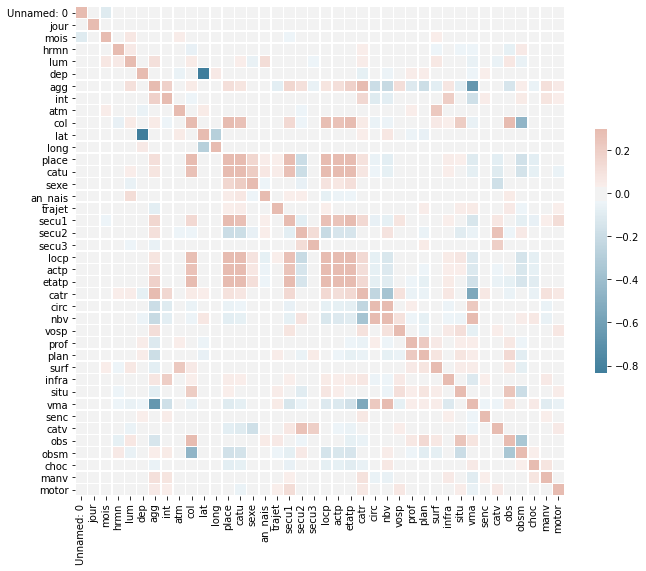

In [6]:
corr = df_utiles.drop(['an', 'grav'], axis=1).corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Test ARIMA pour anticiper nbre accidents**

In [7]:
pip install statsmodels #statsmodels, pour utiliser le module de séries temp SARIMAX

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#statsmodels,'


In [8]:
# ARIMA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX = modèle de séries temp

**But : obtenir la colonne nbre_acc_j qui représente le nombre d'accidents par jour**

In [9]:
from datetime import date
df_utiles = pd.read_csv('df_utiles.csv')
# la colonne "jour_format_normal" contient la date au format standard dd/mm/yyyy
df_utiles["jour_format_normal"] = 0 # Initialisation de la colonne
df_utiles["jour_format_normal"] = df_utiles["jour"].astype(str)+'/'+df_utiles["mois"].astype(str)+'/'+df_utiles["an"].astype(str)
df_utiles["jour_format_normal"] = pd.to_datetime(df_utiles["jour_format_normal"], format="%d/%m/%Y")
df_utiles["colonne_soustraction"] = date(df_utiles["an"].iloc[0], 1, 1) # Création d'une colonne remplie avec la date du 01/01/2019
df_utiles["colonne_soustraction"] = pd.to_datetime(df_utiles["colonne_soustraction"]) #Pour transformer en objet date 
df_utiles["nbre_j"] = df_utiles["jour_format_normal"] - df_utiles["colonne_soustraction"] # Permet d'obtenir une colonne contenant, pour chaque accident,
# Le nombre de jours écoulés depuis le 01/01/2019

def datification(x):
    return x.days # Permet d'obtenir l'entier contenu par l'objet "date" de Python
df_utiles["nbre_j"] = df_utiles["nbre_j"].apply(datification) #Maintenant nbre_j est une colonne d'entiers
nbre_acc_j = df_utiles.groupby(['nbre_j']).agg('count').jour.values #Nbre d'accidents (ou de victimes d'accidents jsp) par jour
ts = pd.Series(nbre_acc_j, index=pd.date_range("1/1/2019", periods=365)) # Objet Series de pandas, pour faire des graphes

**SARIMAX : prédire nbre d'accidents en s'appuyant sur les données déjà enregistrées**

**Graphe d'autocorrélation (les deux dernières lignes de code font planter Jupyter donc sont en commentaire)**

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

# Subtract the rolling mean
nbre_acc_j_dataframe = pd.DataFrame(nbre_acc_j)
nbre_acc_rolling = nbre_acc_j_dataframe - nbre_acc_j_dataframe.rolling(15).mean()

# Drop the NaN values
nbre_acc_rolling = nbre_acc_rolling.dropna()

# Create figure and subplots
#fig, ax1 = plt.subplots()

# Plot the ACF
#plot_acf(nbre_acc_rolling, lags=25, zero=False, ax=ax1);

Conclusion : la composante saisonale a pour période 7 (abscisse du max sur le plot ci-dessus)

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create a SARIMAX model
model = SARIMAX(nbre_acc_j, order=(5, 0, 0), seasonal_order=(1, 1, 0, 7)) # Le 7 correspond à la période déterminée ci-dessus

# Fit the model
results = model.fit()

# Print the results summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  365
Model:             SARIMAX(5, 0, 0)x(1, 1, 0, 7)   Log Likelihood               -1939.442
Date:                           Wed, 29 Dec 2021   AIC                           3892.884
Time:                                   23:24:55   BIC                           3920.048
Sample:                                        0   HQIC                          3903.687
                                           - 365                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2613      0.052      5.074      0.000       0.160       0.362
ar.L2          0.1273      0.057      2.221      0.026       0.015       0.240
ar.L3          0.0942      0.055      1.725      0.085      -0.013       0.201
ar.L4          0.0820      0.058      1.416      0.157      -0.031       0.195
ar.L5          0.0144      0.056      0.256      0.798      -0.096       0.125
ar.S.L7       -0.3782      0.051     -7.450      0.000      -0.478      -0.279
sigma2      2961.9204    210.258     14.087      0.000    2549.822    3374.019
===================================================================================
Ljung-Box (Q):                       94.09   Jarque-Bera (JB):                 4.15
Prob(Q):                              0.00   Prob(JB):                         0.13
Heteroskedasticity (H):               1.49   Skew:                            -0.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
results_pred = results.get_forecast(31) #Utilise le modèle précédent afin de prédire 31 nouvelles valeurs (mois de janvier 2020)
results_mean = results_pred.predicted_mean #Je ne sais pas trop
results_mean = pd.DataFrame(results_mean) #En objet dataframe
results_final = nbre_acc_j_dataframe.append(results_mean) #On adjoint les 31 prédictions aux valeurs réelles afin de tout afficher
results_final = results_final.reset_index() #Après cette fusion de dataframe, l'index est cassé, on le réinitialise donc
results_final = results_final.drop("index", axis=1) #La commande précédent ajoute une colonne "index" inutile dans le DataFrame, on la supprime
date_index = pd.date_range('1/1/2019', periods=396, freq='D') #Pour avoir les dates en abscisse (365 + 31 = 396 jours)
results_final = results_final.set_index(date_index)
print(results_final)

                     0
2019-01-01  263.000000
2019-01-02  239.000000
2019-01-03  255.000000
2019-01-04  298.000000
2019-01-05  287.000000
...                ...
2020-01-27  288.707718
2020-01-28  285.484090
2020-01-29  209.327054
2020-01-30  274.996645
2020-01-31  317.725944

[396 rows x 1 columns]


# Récupération des frontières des régions françaises

In [14]:
#Au cas où la cellule suivante ne marche pas
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
fr_regions = pd.read_json('https://france-geojson.gregoiredavid.fr/repo/regions.geojson')
fr_regions = fr_regions.to_json()
print(df_utiles) # Les frontières des régions françaises (en geojson) sont stockées dans fr_regions

        Unnamed: 0  jour  mois    an  hrmn  lum  dep  agg  int  atm  ...  \
0                0    30    11  2019    60    4   93    1    1    1  ...   
1                1    30    11  2019    60    4   93    1    1    1  ...   
2                2    30    11  2019    60    4   93    1    1    1  ...   
3                3    30    11  2019   120    3   93    1    1    1  ...   
4                4    28    11  2019   900    1   92    1    1    1  ...   
...            ...   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...   
132972      132972    27    11  2019   420    1   67    1    1    8  ...   
132973      132973    30    11  2019   120    4   94    1    1    1  ...   
132974      132974    30    11  2019   900    1   78    1    1    1  ...   
132975      132975    29    11  2019  1200    3   92    1    1    1  ...   
132976      132976    29    11  2019  1200    3   92    1    1    1  ...   

        senc catv obs  obsm  choc  manv  motor  jour_format_normal  \
0          2    7

In [16]:
variables_utiles_regr = ['nbre_j', 'hrmn', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'col', 'catr', 'prof', 'plan', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe', 'grav', 'an_nais']
variables_utiles_regr_sans_grav = ['nbre_j', 'hrmn', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'col', 'catr', 'prof', 'plan', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe', 'an_nais']
from sklearn import model_selection # Pour utiliser RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier #
from sklearn.model_selection import cross_val_score #Pour mesurer la précision de l'algo
from sklearn.metrics import classification_report, confusion_matrix #
from sklearn.utils import shuffle # Pour que le scoring "roc_auc" fonctionne
from sklearn.preprocessing import label_binarize # Transformer y en variable catégorique
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

# A faire : vérifier que les données sont centrées-réduites
# A faire : changer les différents paramètres pour tester

df_rayon = []
df_rayon = df_utiles[variables_utiles_regr] # On ne retient que les variables utiles
df_rayon = pd.DataFrame(df_rayon)
X = df_rayon[variables_utiles_regr_sans_grav] # Tout le dataframe sans la colonne "grav" qu'on cherche à prédire
y = df_rayon.grav #colonne "grav"
X, y = shuffle(X, y)
X = pd.DataFrame(X)
y = y.astype(int) #Pour s'assurer que y est une colonne d'int
y = label_binarize(y, classes=[0, 1]) #Pour faire du one-hot encoding sur y
y = pd.DataFrame(y)
os = SMOTE(random_state=0) #Initialisation de SMOTE, pour avoir 50 % de 0 et 50 % de 1 dans y (sans modifier la distribution de l'échantillon d'accidents)
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1) #K-Fold répété, augmente la précision de l'algo de ~10 %
for train_index, test_index in cv.split(X): #On remplit X_train, X_test, Y_train et Y_test pour fitter et tester l'algo
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
rfc = RandomForestClassifier() # On charge une instance de RandomForestClassifier
rfc.fit(X_train,y_train) #On fit sur l'ensemble d'entraînement
rfc_predict = rfc.predict(X_test) #On teste
#rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc') #On évalue le score
cm = confusion_matrix(y_test.values.argmax(axis=1), rfc_predict.argmax(axis=1))
precision = (cm[0][0] + cm[1][1])/(cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision2 = accuracy_score(y_test, rfc_predict) # Même chose que la variable precision

def random_forest(pred):
    return [precision2*100, rfc.predict(pred)]

ValueError: could not convert string to float: '43,3700870'

In [17]:
variables_utiles_regr = ['nbre_j', 'hrmn', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'col', 'catr', 'prof', 'plan', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe', 'grav', 'an_nais']
variables_utiles_regr_sans_grav = ['nbre_j', 'hrmn', 'lum', 'lat', 'long', 'agg', 'int', 'atm', 'col', 'catr', 'prof', 'plan', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe', 'an_nais']
variables_utiles_cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'prof', 'plan', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe']
variables_utiles_num = ['nbre_j', 'hrmn', 'lat', 'long', 'an_nais']
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
import pickle # Pour sauvegarder le modèle de OneHotEncoding

# A faire : vérifier que les données sont centrées-réduites
# A faire : changer les différents paramètres pour tester
    
df_rayon = []
df_rayon = df_utiles[variables_utiles_regr] # On ne retient que les variables utiles
df_rayon = pd.DataFrame(df_rayon)
enc = OneHotEncoder(handle_unknown='ignore') #OneHotEncoder pour les variables catégorielles

for var in variables_utiles_cat: # On parcourt les variables utiles catégorielles
    df_rayon[var] = enc.fit_transform(df_rayon[var].values.reshape(-1, 1)).todense()
pickle.dump(enc, open('onehot.pickle', 'wb'))

X = df_rayon[variables_utiles_regr_sans_grav] # Tout le dataframe sans la colonne "grav" qu'on cherche à prédire
y = df_rayon.grav #colonne "grav"
X, y = shuffle(X, y)
X = pd.DataFrame(X)
y = y.astype(int) #Pour s'assurer que y est une colonne d'int
y = label_binarize(y, classes=[0, 1]) #Pour faire du one-hot encoding sur y
y = pd.DataFrame(y)
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1) #K-Fold répété, augmente la précision de l'algo de ~10 %
for train_index, test_index in cv.split(X): #On remplit X_train, X_test, Y_train et Y_test pour fitter et tester l'algo
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model = Sequential()
model.add(Dense(64, input_dim=22, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size=10)
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

def output_NN_Keras(output):
    if output[0][0] > 0.5:
        return 'Décès'
    else:
        return 'Survie'

def NN_Keras(pred):
    pred = np.asarray(pred).astype('float32')
    pred = pd.DataFrame(np.reshape(pred, (1, -1)), columns=[['input_nbre_j', 'input_hrmn', 'input_lat', 'input_long', 'input_an_nais', 'lum', 'agg', 'int', 'atm', 'col', 'catr', 'prof', 'plan', 'surf', 'infra', 'situ', 'catv', 'obs', 'obsm', 'choc', 'catu', 'sexe']])
    loaded_enc = pickle.load(open("onehot.pickle", "rb"))
    for var in variables_utiles_cat: # On parcourt les variables utiles catégorielles
        pred[var] = loaded_enc.fit_transform(pred[var].values.reshape(-1, 1)).todense()
    return [accuracy*100, output_NN_Keras(model.predict(pred))]

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

# On obtient 80 % de précision avec un RandomForestClassifier

In [ ]:
## Dash app (https://dash.plot.ly/getting-started)

import numpy as np

import dash # Dash
import dash_core_components as dcc # Pour utiliser dcc.Input (ce qui permet d'inclure les inputs dans le HTML)
import dash_html_components as html # L'interface Dash est en HTML
from dash.dependencies import Input, Output, State, MATCH, ALL # Pour les callbacks

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css'] # Feuille CSS externe, pour mettre en forme la dashboard

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

NUMBER_VAR = (
    'nbre_j', 'hrmn', 'lat', 'long', 'an_nais'
) # Liste des variables sur lesquelles on utilise l'algo

app.layout = html.Div(children=[ #Toute l'app est une balise div, qui contient des balises H1, ..., H6 (pour les titres) et des balises Div pour tous les contenus interactifs
    html.H1(children='Prédictions'),
    html.Div([
        dcc.Graph(id="Carte",figure=px.scatter_geo(df_utiles.head(1000), lat="lat", lon="long", geojson=fr_regions))] # Carte affichant les accidents sur une carte de France
    ,style={'columnCount': 1}), 
    html.Div([
        dcc.Graph(id="Prédictions",figure=px.line(results_final, labels={'x': 'jour', 'y': 'nombre d\'accidentés'}))] #Prédictions SARIMAX
    ,style={'columnCount': 1}), 
    html.Div(children='''
        Remplir les variables
    '''),
            html.Div( # Cette balise Div permet d'afficher les inputs sur l'interface Dash, pour qu'on puisse les remplir
    [
        dcc.Input(
            id="input_{}".format(_), # On identifie chaque Input par un ID "input_nomdelavariable", utile pour les callbacks
            type="number",
            placeholder="variable {}".format(_),
        )
        for _ in NUMBER_VAR # On affiche les inputs pour les variables quantitatives (non catégorielles)
    ]),
            html.Div([
    dcc.Dropdown(
        id='lum',
        options=[
            {'label': 'Plein jour', 'value': '1'},
            {'label': 'Crépuscule ou aube', 'value': '2'},
            {'label': 'Nuit sans éclairage public', 'value': '3'},
            {'label': 'Nuit avec éclairage public non allumé', 'value': '4'},
            {'label': 'Nuit avec éclairage public allumé', 'value': '5'}
        ],
        placeholder="Conditions d'éclairage"
    )]),
    
            html.Div([
    dcc.Dropdown(
        id='catv',
        options=[
            {'label': 'Indéterminable/piéton', 'value': '0'},
            {'label': 'Véhicule léger (voiture, utilitaire)', 'value': '1'},
            {'label': 'Sans permis (< 125 cm3) (vélo, scooter, ...)', 'value': '2'},
            {'label': 'Poids lourd', 'value': '3'},
            {'label': 'Transport en commun', 'value': '4'},
            {'label': '> 125 cm3 à 2/3 roues', 'value': '5'}
        ],
        placeholder="Type de véhicule de l'individu"
    )]),
    
    
             html.Div([
    dcc.Dropdown(
        id='agg',
        options=[
            {'label': 'Hors agglomération', 'value': '1'},
            {'label': 'En agglomération', 'value': '2'}
        ],
        placeholder="En agglo ou non"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='int',
        options=[
            {'label': 'Hors intersection', 'value': '1'},
            {'label': 'Intersection en X', 'value': '2'},
            {'label': 'Intersection en T', 'value': '3'},
            {'label': 'Intersection en Y ', 'value': '4'},
            {'label': 'Intersection à plus de 4 branches', 'value': '5'},
            {'label': 'Giratoire', 'value': '6'},
            {'label': 'Place ', 'value': '7'},
            {'label': 'Passage à niveau ', 'value': '8'},
            {'label': 'Autre intersection', 'value': '9'}
        ],
        placeholder="Type d'intersection"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='atm',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Normale', 'value': '1'},
            {'label': 'Pluie légère', 'value': '2'},
            {'label': 'Pluie forte', 'value': '3'},
            {'label': 'Neige - grêle', 'value': '4'},
            {'label': 'Brouillard - fumée', 'value': '5'},
            {'label': 'Vent fort - tempête', 'value' : '6'},
            {'label': 'Temps éblouissant', 'value': '7'},
            {'label': 'Temps couvert', 'value': '8'},
            {'label': 'Autre', 'value': '9'}
        ],
        placeholder="Conditions météorologiques au moment de l'accident"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='col',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Deux véhicules - frontale', 'value': '1'},
            {'label': 'Deux véhicules – par l’arrière', 'value': '2'},
            {'label': 'Deux véhicules – par le coté', 'value': '3'},
            {'label': 'Trois véhicules et plus – en chaîne', 'value': '4'},
            {'label': 'Trois véhicules et plus - collisions multiples', 'value': '5'},
            {'label': ' Autre collision', 'value' : '6'},
            {'label': 'Sans collision', 'value': '7'}
        ],
        placeholder="Type de collision"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='catr',
        options=[
            {'label': 'Autoroute', 'value': '1'},
            {'label': 'Route nationale', 'value': '2'},
            {'label': 'Route Départementale', 'value': '3'},
            {'label': 'Voie Communales', 'value': '4'},
            {'label': 'Hors réseau public', 'value': '5'},
            {'label': 'Parc de stationnement ouvert à la circulation publique', 'value': '6'},
            {'label': 'Routes de métropole urbaine', 'value': '7'},
            {'label': 'autre', 'value': '9'}
        ],
        placeholder="Type de route"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='prof',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Plat', 'value': '1'},
            {'label': 'Pente', 'value': '2'},
            {'label': 'Sommet de côte', 'value': '3'},
            {'label': 'Bas de côte', 'value': '4'}
        ],
        placeholder="Profil (déclivité)"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='plan',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Partie rectiligne', 'value': '1'},
            {'label': 'En courbe à gauche', 'value': '2'},
            {'label': 'En courbe à droite', 'value': '3'},
            {'label': 'En S', 'value': '4'}
        ],
        placeholder="Tracé en plan"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='surf',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Normale', 'value': '1'},
            {'label': 'Mouillée', 'value': '2'},
            {'label': 'Flaques', 'value': '3'},
            {'label': 'Inondée', 'value': '4'},
            {'label': 'Enneigée', 'value': '5'},
            {'label': 'Boue', 'value' : '6'},
            {'label': 'Verglacée', 'value': '7'},
            {'label': 'Corps gras - huile', 'value': '8'},
            {'label': 'Autre', 'value': '9'}
        ],
        placeholder="Surface de la chaussée"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='infra',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Souterrain - tunnel', 'value': '1'},
            {'label': 'Pont - autopont', 'value': '2'},
            {'label': 'Bretelle d’échangeur ou de raccordement', 'value': '3'},
            {'label': 'Voie ferrée', 'value': '4'},
            {'label': 'Carrefour aménagé', 'value': '5'},
            {'label': 'Zone piétonne', 'value' : '6'},
            {'label': 'Zone de péage', 'value': '7'},
            {'label': 'Chantier', 'value': '8'},
            {'label': 'Autres', 'value': '9'}
        ],
        placeholder="Type d'infrastructures/aménagement"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='situ',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Sur chaussée', 'value': '1'},
            {'label': 'Sur bande d’arrêt d’urgence', 'value': '2'},
            {'label': 'Sur accotement', 'value': '3'},
            {'label': 'Sur trottoir', 'value': '4'},
            {'label': 'Sur piste cyclable', 'value': '5'},
            {'label': 'Sur autre voie spéciale', 'value' : '6'},
            {'label': 'Autres', 'value': '8'}
        ],
        placeholder="Situation de l'accident"
    )]),
             html.Div([
    dcc.Dropdown(
        id='obs',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Sans objet', 'value': '0'},
            {'label': 'Véhicule en stationnement', 'value': '1'},
            {'label': 'Arbre', 'value': '2'},
            {'label': 'Glissière métallique', 'value': '3'},
            {'label': 'Glissière béton', 'value': '4'},
            {'label': 'Autre glissière', 'value': '5'},
            {'label': 'Bâtiment, mur, pile de pont', 'value' : '6'},
            {'label': 'Support de signalisation verticale ou poste d’appel d’urgence', 'value': '7'},
            {'label': 'Poteau', 'value': '8'},
            {'label': 'Mobilier urbain', 'value': '9'},
            {'label': 'Parapet', 'value': '10'},
            {'label': 'Ilot, refuge, borne haute', 'value': '11'},
            {'label': 'Bordure de trottoir', 'value': '12'},
            {'label': 'Fossé, talus, paroi rocheuse', 'value': '13'},
            {'label': 'Autre obstacle fixe sur chaussée', 'value': '14'},
            {'label': 'Autre obstacle fixe sur trottoir ou accotement', 'value': '15'},
            {'label': 'Sortie de chaussée sans obstacle', 'value': '16'},
            {'label': 'Buse – tête d’aqueduc', 'value': '17'}
        ],
        placeholder="Obstacle fixe percuté"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='obsm',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Piéton', 'value': '1'},
            {'label': 'Véhicule', 'value': '2'},
            {'label': 'Véhicule sur rail', 'value': '4'},
            {'label': 'Animal domestique', 'value': '5'},
            {'label': 'Animal sauvage', 'value' : '6'},
            {'label': 'Autre', 'value': '9'}
        ],
        placeholder="Obstacle mobile percuté"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='choc',
        options=[
            {'label': 'Non renseigné', 'value': '-1'},
            {'label': 'Aucun', 'value': '0'},
            {'label': 'Avant', 'value': '1'},
            {'label': 'Avant droit', 'value': '2'},
            {'label': 'Avant gauche', 'value': '3'},
            {'label': 'Arrière', 'value': '4'},
            {'label': 'Arrière droit', 'value': '5'},
            {'label': 'Arrière gauche', 'value' : '6'},
            {'label': 'Côté droit', 'value': '7'},
            {'label': 'Côté gauche', 'value': '8'},
            {'label': 'Chocs multiples (tonneaux)', 'value': '9'}
        ],
        placeholder="Point de choc initial"
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='catu',
        options=[
            {'label': 'Conducteur', 'value': '1'},
            {'label': 'Passager', 'value': '2'},
            {'label': 'Piéton', 'value': '3'}
        ],
        placeholder="L'individu est..."
    )]),
             
             html.Div([
    dcc.Dropdown(
        id='sexe',
        options=[
            {'label': 'Masculin', 'value': '1'},
            {'label': 'Féminin', 'value': '2'}
        ],
        placeholder="Sexe de l'individu"
    )]),
    html.Div(id="out-all-types")
])

@app.callback(
     Output("out-all-types", "children"),
     [Input("input_{}".format(_), "value") for _ in NUMBER_VAR], # On lie les inputs affichés sur Dash et la fonction cb_render
     Input("lum", "value"),
     Input("agg", "value"),
     Input("int", "value"),
     Input("atm", "value"),
     Input("col", "value"),
     Input("catr", "value"),
     Input("prof", "value"),
     Input("plan", "value"),
     Input("surf", "value"),
     Input("infra", "value"),
     Input("situ", "value"),
     Input("catv", "value"),
     Input("obs", "value"),
     Input("obsm", "value"),
     Input("choc", "value"),
     Input("catu", "value"),
     Input("sexe", "value"),
)
def cb_render(*vals):
    if not None in vals:
        float_vals = []
        for item in vals:
            float_vals.append(float(item))
        res = NN_Keras(vals)
        return "L'algorithme prédit : {}, avec une précision de {}".format(res[1], res[0]) 

if __name__ == '__main__':
    app.run_server(host='127.0.0.1', port='8050')

<ipython-input-18-2451bf8e6d76>:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc # Pour utiliser dcc.Input (ce qui permet d'inclure les inputs dans le HTML)
<ipython-input-18-2451bf8e6d76>:7: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html # L'interface Dash est en HTML


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [29/Dec/2021 23:30:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Dec/2021 23:30:31] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_0_0m1640123271.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Dec/2021 23:30:31] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_0_0m1640123271.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Dec/2021 23:30:31] "GET /_dash-component-suites/dash/deps/react@16.v2_0_0m1640123271.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Dec/2021 23:30:31] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_0_0m1640123271.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Dec/2021 23:30:31] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v2_0_0m1640123271.min.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Dec/2021 23:30:31] "GET /_dash-component-suites/dash/dcc/dash_core_components.v2_0_0m1640123271.js HTTP/1.1" 200 -
127.0.0.1 - - [29/Dec/2021 23:30:31] "GET /_dash-component-suites/d

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "D:\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "D:\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "D:\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "D:\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "D:\anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "D:\anaconda3\lib\site-packages\dash\dash.py", line 1336, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "D:\anaconda3\lib\site-packages\d

127.0.0.1 - - [29/Dec/2021 23:33:17] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "D:\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "D:\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "D:\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "D:\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "D:\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "D:\anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "D:\anaconda3\lib\site-packages\dash\dash.py", line 1336, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "D:\anaconda3\lib\site-packages\d

127.0.0.1 - - [29/Dec/2021 23:33:17] "POST /_dash-update-component HTTP/1.1" 500 -
